# Using LittleVGG for Emotion Detection

### Training Emotion Detector

In [6]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os

num_classes = 6
img_rows, img_cols = 32, 32
batch_size = 32

train_data_dir = 'train'
validation_data_dir = 'validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      width_shift_range=0.4,
      height_shift_range=0.4,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


## Our Keras Imports

In [20]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.layers.core import Activation, Flatten, Dropout, Dense

## Keras LittleVGG Model

In [21]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = 'same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding = "same", kernel_initializer="he_normal", 
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #2: second CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #3: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #4: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #: third CONV => RELU => CONV => RELU => POOL
# layer set
model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), padding="same", kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: second set of FC => RELU layers
model.add(Dense(64, kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer="he_normal"))
model.add(Activation("softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
activation_53 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_54 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
__________

## Training our model

In [22]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("emotion_little_vgg_3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy'])

nb_train_samples = 28273
nb_validation_samples = 3534
epochs = 30

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/30
883/883 [==============================] - 1143s 1s/step - loss: 1.8034 - acc: 0.2382 - val_loss: 1.7450 - val_acc: 0.2491

Epoch 00001: val_loss improved from inf to 1.74502, saving model to emotion_little_vgg_3.h5
Epoch 2/30
883/883 [==============================] - 1045s 1s/step - loss: 1.7409 - acc: 0.2580 - val_loss: 1.7632 - val_acc: 0.2444

Epoch 00002: val_loss did not improve from 1.74502
Epoch 3/30
883/883 [==============================] - 1091s 1s/step - loss: 1.7415 - acc: 0.2563 - val_loss: 1.7742 - val_acc: 0.2287

Epoch 00003: val_loss did not improve from 1.74502
Epoch 4/30
883/883 [==============================] - 1159s 1s/step - loss: 1.7402 - acc: 0.2551 - val_loss: 1.7416 - val_acc: 0.2524

Epoch 00004: val_loss improved from 1.74502 to 1.74156, saving model to emotion_little_vgg_3.h5
Epoch 5/30
883/883 [==============================] - 1164s 1s/step - loss: 1.7341 - acc: 0.2575 - val_loss: 1.7482 - val_acc: 0.2533

Epoch 00005: val_loss did not impro

Found 3534 images belonging to 6 classes.
Confusion Matrix
[[  0  44  85 179 148  35]
 [  0  68  90 152 130  88]
 [  0  13 763  12  74  17]
 [  0  41 188 194 127  76]
 [  0  28  96 231 222  17]
 [  0  26  64  31  12 283]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00       491
        Fear       0.31      0.13      0.18       528
       Happy       0.59      0.87      0.70       879
     Neutral       0.24      0.31      0.27       626
         Sad       0.31      0.37      0.34       594
    Surprise       0.55      0.68      0.61       416

   micro avg       0.43      0.43      0.43      3534
   macro avg       0.33      0.39      0.35      3534
weighted avg       0.35      0.43      0.38      3534



/Users/abuzaid/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


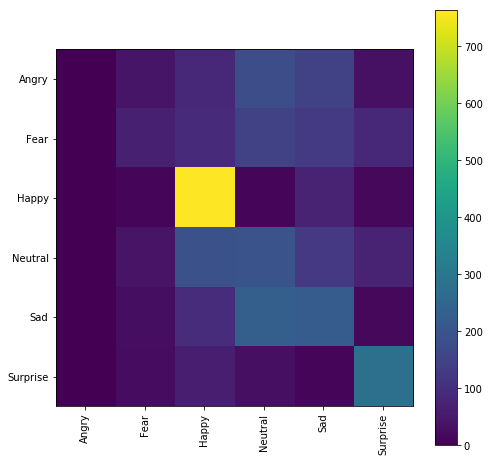

In [23]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 28273
nb_validation_samples = 3534

# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Loading our saved model

In [1]:
from keras.models import load_model

classifier = load_model('emotion_little_vgg_3.h5')

Using TensorFlow backend.
W0614 14:39:38.840416 4609353152 deprecation_wrapper.py:119] From /Users/abuzaid/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 14:39:38.870368 4609353152 deprecation_wrapper.py:119] From /Users/abuzaid/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0614 14:39:38.943194 4609353152 deprecation_wrapper.py:119] From /Users/abuzaid/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 14:39:38.945096 4609353152 deprecation_wrapper.py:119] From /Users/abuzaid/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use t

### Get our class labels

In [12]:
validation_generator = validation_datagen.flow_from_directory(
        'validation',
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 3534 images belonging to 6 classes.
{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}


### Let's test on some of validation images

In [9]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale=True), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32

# We use a very small learning rate 
classifier.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 10):
    path = 'validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

/Users/abuzaid/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


### Test on a single image

In [7]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((32,32), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (32, 32), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("rajeev.jpg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    
cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

### Let's try this on our webcam


In [10]:
import cv2
import numpy as np
from time import sleep
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((32,32), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (32, 32), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((32,32), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture(0)

while True:

    ret, frame = cap.read()
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    cv2.imshow('All', image)
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

In [11]:
cap.release()
cv2.destroyAllWindows()      